# GLM

In [1]:
# ---------- CONFIG ----------
PIX_PER_DEG_THINGS = 25.8601  # pixels per degree, from mapping.py
monkey = 'monkeyN' # monkeyF
out_size = (64, 64)  # RF grid resolution: 64x64 "sensors" (stimulus pixels); 128 is already crashing my system
n_subset = 1000 # random subset of >22248 images in train set
E_SUBSET = 64 # None
if E_SUBSET is not None:
    assert E_SUBSET % 64 == 0
shuffle_mapping = False # Shuffle true mapping of MUA - image. acts as sanity check.
reg = None #l1, l2, elastic
VERBOSE = False
# ElasticNet for a balance between sparsity and smoothness
# l1 ~
alpha = 0.1
l1_ratio = 0.8
# Vis
vlim = (-1e-4, 1e-4)

In [2]:
# ---------- IMPORTS ----------
import os
import numpy as np
from PIL import Image
import h5py
import matplotlib.pyplot as plt
from os.path import join
# ---------- DIR ----------
wd = r"E:\radboud\Masters Thesis"
# image-side tree
image_side_dir = join(wd, 'source data', 'image data')
things_dir = join(image_side_dir, 'THINGS')
object_images_dir = os.path.join(things_dir,"images_THINGS", "object_images")
# ephys side tree
ephys_side_dir = join(wd, 'source data', 'neural data')
tvsd_dir = join(ephys_side_dir, 'TVSD')
log_path = join(tvsd_dir, monkey, '_logs')
image_MUA_mapping = join(log_path, 'things_imgs.mat') # mapping
normMUA_path = join(tvsd_dir, monkey, 'THINGS_normMUA.mat')
# derivatives tree
derivatives_ephys_dir = join(wd, 'derivatives', 'neural data', 'TVSD')
derivatives_rf_dir = join(derivatives_ephys_dir, monkey, 'ReceptiveFields')
# ana tree
ana_dir = join(wd, 'analysis', 'TVSD')
ana_monkey_dir = join(ana_dir, monkey)
# 

In [3]:
# ---------- image side helpers ----------
def prepare_THINGS_objects(image_MUA_mapping, verbose = False):
    with h5py.File(image_MUA_mapping, "r") as f:
        train_group = f["train_imgs"]
        test_group  = f["test_imgs"]

        class_refs       = train_group["class"][()]        # (22248,)
        local_path_refs  = train_group["local_path"][()]   # (22248,)
        things_path_refs = train_group["things_path"][()]  # (22248,)

        print("class_refs shape:", class_refs.shape, "dtype:", class_refs.dtype)
        print("local_path_refs shape:", local_path_refs.shape, "dtype:", local_path_refs.dtype)
        print("things_path_refs shape:", things_path_refs.shape, "dtype:", things_path_refs.dtype)

        def unwrap_ref(ref):
            """
            Unwrap a reference that may be:
            - an h5py.Reference
            - a 0-d or 1-d numpy array containing a Reference
            and return a true h5py.Reference.
            """
            # Direct reference
            if isinstance(ref, h5py.Reference):
                return ref

            # 0-d / 1-d numpy array wrapping the reference
            arr = np.array(ref)
            if arr.dtype == object and arr.size > 0:
                inner = arr.ravel()[0]
                if isinstance(inner, h5py.Reference):
                    return inner
                # if it's still an array, recurse once
                if isinstance(inner, np.ndarray):
                    return unwrap_ref(inner)

            # Fallback: just try to treat ref as-is (will error if wrong)
            return ref

        def dset_to_str(dset):
            """
            Convert a dataset (often MATLAB char array) to a Python string.
            Handles:
            - bytes
            - numpy arrays of 'S'/'U'
            - numpy arrays of uint16/int16/int32 char codes
            """
            data = dset[()]  # grab contents

            # plain python types
            if isinstance(data, bytes):
                return data.decode("utf-8")
            if isinstance(data, str):
                return data

            arr = np.array(data)

            # string-like arrays
            if arr.dtype.kind in {"S", "U"}:
                flat = arr.ravel()
                parts = []
                for x in flat:
                    if isinstance(x, (bytes, bytearray)):
                        parts.append(x.decode("utf-8"))
                    else:
                        parts.append(str(x))
                return "".join(parts)

            # numeric char codes (MATLAB-style)
            if arr.dtype in (np.uint16, np.int16, np.int32, np.int64):
                chars = [chr(int(c)) for c in arr.ravel() if int(c) != 0]
                return "".join(chars)

            # last resort
            return str(arr)

        def refs_to_str_array(refs):
            strings = []
            for ref in refs:
                href = unwrap_ref(ref)
                dset = f[href]           # <--- this is where we previously passed an ndarray
                s = dset_to_str(dset)
                strings.append(s)
            return np.array(strings, dtype=object)

        train_class       = refs_to_str_array(class_refs)
        train_local_path  = refs_to_str_array(local_path_refs)
        train_things_path = refs_to_str_array(things_path_refs)
    if verbose:
        print('structure overview for index 0:')
        print("train_class[0]:      ", train_class[0])
        print("train_local_path[0]: ", train_local_path[0])
        print("train_things_path[0]:", train_things_path[0])
        print("n_train:", len(train_things_path))

    return train_class, train_local_path, train_things_path 

from PIL import Image
def load_image_downsample_gray(rel_path, root, size, verbose=False):
    """
    Load an image given a relative path, convert to grayscale, resize, and
    normalize to [0, 1].

    Args:
        rel_path: relative path to image (e.g. "aardvark/aardvark_01b.jpg")
        root: root directory where images live
        size: (H, W) tuple for resizing
        verbose: if True, print debug info

    Returns:
        arr: np.ndarray of shape (H, W), float32 in [0, 1]
    """
    img_path = os.path.join(root, rel_path)

    if verbose:
        print(f"[load_image] Loading: {img_path}")

    img = Image.open(img_path).convert("L")  # grayscale
    orig_w, orig_h = img.size
    #print(img.size)
    if verbose:
        print(f"[load_image] Original size: {orig_w}x{orig_h} -> resizing to {size[0]}x{size[1]}")

    img = img.resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.float32)
    arr /= 255.0  # scale to [0,1]

    if verbose:
        print(f"[load_image] After resize: shape={arr.shape}, "
              f"min={arr.min():.3f}, max={arr.max():.3f}")

    return arr

In [4]:
# ---------- RF HELPERS ----------
def build_stimulus_and_response(
    image_paths,
    responses,
    root,
    size,
    idxs=None,
    verbose=True,
):
    """
    Build stimulus matrix X and response matrix R.

    Args:
        image_paths: array-like of length N_all with relative image paths.
        responses: np.ndarray of shape (N_all, E) with MUA responses.
        root: root directory for images.
        size: (H, W) for downsampled grayscale images.
        idxs: optional indices of images to use; if None, use all.
        verbose: if True, print debug info.

    Returns:
        X: np.ndarray of shape (N, D)  (N images, D pixels)
        R: np.ndarray of shape (N, E)  (N images, E electrodes)
        img_shape: tuple (H, W)
    """
    image_paths = np.asarray(image_paths)
    N_all = len(image_paths)

    if idxs is None:
        idxs = np.arange(N_all)
        if verbose:
            print(f"[build_SR] Using ALL {N_all} training images.")
    else:
        idxs = np.asarray(idxs)
        if verbose:
            print(f"[build_SR] Using subset of {len(idxs)} images out of {N_all} total.")

    N = len(idxs)
    E = responses.shape[1]

    # Load first image once to infer shape
    if verbose:
        print(f"[build_SR] Loading first example image at index {idxs[0]} for shape inference.")
    example_img = load_image_downsample_gray(image_paths[idxs[0]], root=root, size=size, verbose=verbose)
    H, W = example_img.shape
    D = H * W

    if verbose:
        print(f"[build_SR] Image shape: {H}x{W} -> D={D} pixels per image.")
        print(f"[build_SR] Number of electrodes E={E}")
        print(f"[build_SR] Allocating X with shape (N={N}, D={D}), R with shape (N={N}, E={E})")

    X = np.zeros((N, D), dtype=np.float32)
    R = np.zeros((N, E), dtype=np.float32)

    # Fill first row with example_img so we don't reload it
    X[0, :] = example_img.flatten()
    R[0, :] = responses[idxs[0], :]

    # Loop over remaining indices
    for k, i in enumerate(idxs[1:], start=1):
        if verbose and (k % max(1, N // 10) == 0):
            print(f"[build_SR] Processing image {k+1}/{N} (train index {i})")

        arr = load_image_downsample_gray(image_paths[i], root=root, size=size, verbose=False)
        X[k, :] = arr.flatten()
        R[k, :] = responses[i, :]

    if verbose:
        print(f"[build_SR] Done. X shape: {X.shape}, R shape: {R.shape}")
        print(f"[build_SR] X stats: mean={X.mean():.4f}, std={X.std():.4f}, "
              f"min={X.min():.4f}, max={X.max():.4f}")
        print(f"[build_SR] R stats: mean={R.mean():.4f}, std={R.std():.4f}, "
              f"min={R.min():.4f}, max={R.max():.4f}")

    return X, R, H, W





In [5]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from matplotlib.patches import Rectangle
def plot_rf_grid(
        rf_per_array, array2area,
        monkey,basename = None,
        shuffle_suffix="true_order", vlim=(-0.5, 0.5),
        save_dir=None, 
        dpi=300
    ):
    """
    Dynamically plots RFs for a variable number of arrays.

    rf_per_array: np.ndarray, shape (N_arrays, H, W)
        RFs per array (each corresponding to 64 electrodes).
    array2area: dict
        Mapping from 1-based array number -> area label.
    """
    n_arrays, H, W = rf_per_array.shape
    n_cols = min(4, n_arrays)  # 4 max per row
    n_rows = math.ceil(n_arrays / n_cols)

    fig = plt.figure(figsize=(3.2 * n_cols, 3.2 * n_rows))
    suptitle = f'{monkey} – GLM-based RFs per array ({shuffle_suffix})'
    fig.suptitle(suptitle, fontsize=18)

    gs = GridSpec(
        n_rows,
        n_cols + 1,  # extra column for colorbar
        width_ratios=[1] * n_cols + [0.05],
        wspace=0.4,
        hspace=0.5
    )

    # color limits
    if vlim is None:
        vmax = np.max(np.abs(rf_per_array))
        vmin = -vmax
    else:
        vmin, vmax = vlim

    
    for idx in range(n_arrays):
        r = idx // n_cols
        c = idx % n_cols
        ax = fig.add_subplot(gs[r, c])

        from matplotlib.patches import Rectangle

        rf = rf_per_array[idx]
        im = ax.imshow(rf, cmap="bwr_r", vmin=vmin, vmax=vmax)
        ax.axis("off")

        # Add a black rectangle that exactly bounds the image
        rect = Rectangle(
            xy=(-0.5, -0.5),  # top-left corner (matches imshow default pixel centers)
            width=W, height=H,
            linewidth=1.5, edgecolor='black', facecolor='none'
        )
        ax.add_patch(rect)


        array_num = idx + 1  # 1-based
        area = array2area.get(array_num, "unknown")
        ax.set_title(f"Array {array_num} – {area}", fontsize=11, pad=10)

    # colorbar
    cax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("corr(pixel, MUA)")

    plt.tight_layout(rect=[0, 0, 0.96, 0.95])

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        png_path = os.path.join(save_dir, f"{basename}.png")
        pdf_path = os.path.join(save_dir, f"{basename}.pdf")

        fig.savefig(png_path, dpi=dpi, bbox_inches="tight")
        fig.savefig(pdf_path, dpi=dpi, bbox_inches="tight")
        print(f"[plot_rf_grid_dynamic] Saved PNG to: {png_path}")
        print(f"[plot_rf_grid_dynamic] Saved PDF to: {pdf_path}")

    plt.show()


In [6]:
# IMG 
train_class, train_local_path, train_things_path = prepare_THINGS_objects(image_MUA_mapping, verbose=False)
## class_refs shape: (22248, 1) dtype: object
## local_path_refs shape: (22248, 1) dtype: object
## things_path_refs shape: (22248, 1) dtype: object
## MUA
with h5py.File(normMUA_path, "r") as f:
    SNR           = np.array(f["SNR"])             # (4, 1024)
    SNR_max       = np.array(f["SNR_max"])         # (1024, 1)
    lats          = np.array(f["lats"])            # (4, 1024)
    oracle        = np.array(f["oracle"])          # (1024, 1)
    reliab        = np.array(f["reliab"])          # (435, 1024)
    tb            = np.array(f["tb"])              # (300, 1)
    test_MUA      = np.array(f["test_MUA"])        # (100, 1024)
    test_MUA_reps = np.array(f["test_MUA_reps"])   # (30, 100, 1024)
    train_MUA     = np.array(f["train_MUA"])       # (22248, 1024)

class_refs shape: (22248, 1) dtype: object
local_path_refs shape: (22248, 1) dtype: object
things_path_refs shape: (22248, 1) dtype: object


In [7]:
# PREPARE and ESTIMATE
# specify  images to use for RF estimation
n_total = len(train_things_path)
print(f"[MAIN] Total available training images: {n_total}")

# For speed, potentially use a random subset, REF to n_subset
idxs = np.random.choice(n_total, size=min(n_subset, n_total), replace=False)
print(f"[MAIN] Using {len(idxs)} images for building X.")

# build X (stimuli) and R (responses)
X, R, H, W = build_stimulus_and_response(
    image_paths=train_things_path,
    responses=train_MUA,
    root=object_images_dir,
    size=out_size,
    idxs=idxs,   # or some subset
    verbose=False,
)
print(f"[MAIN] X shape: {X.shape}, R shape: {R.shape}, img_shape: {H, W}")
# --- Monkey N: which Utah array is in which area ---
# WARNING: order is a placeholder – adjust once you know the true array order from TVSD metadata.

if shuffle_mapping:
        N, D = X.shape
        E = R.shape[1]
        # get a random permutation of the N trials
        perm = np.random.permutation(N)        # shape: (N,)
        # shuffle responses relative to stimuli
        R = R[perm, :]    
        order = 'shuffled'
else:            
    order = 'ordered'
    
saving=True
if saving:
    save_dir = join(derivatives_rf_dir, 'linear')
    os.makedirs(save_dir, exist_ok=True)

    data_fname = f"{monkey}_X_R_imgshape{len(idxs)}_{order}.npz"
    save_path = os.path.join(save_dir, data_fname)

    np.savez_compressed(save_path, X=X, R=R, H=H, W=W)
    print(f"[SAVE] Saved stimulus-response data to: {save_path}")



[MAIN] Total available training images: 22248
[MAIN] Using 1000 images for building X.
[MAIN] X shape: (1000, 4096), R shape: (1000, 1024), img_shape: (64, 64)
[SAVE] Saved stimulus-response data to: E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_X_R_imgshape1000_ordered.npz


In [8]:
## LOADING
# Construct load path
loading=False
if loading:
    if shuffle_mapping:
        order = 'shuffled'
    else:
        order = 'ordered'
    len_idxs = 5000 # how many images to include
    load_path = join(derivatives_rf_dir, 'linear', f"{monkey}_X_R_imgshape{len_idxs}_{order}.npz")

    # Load .npz file
    loaded = np.load(load_path)
    X = loaded["X"]
    R = loaded["R"]
    H = int(loaded["H"])
    W = int(loaded["W"])

    print(f"[LOAD] Loaded X shape: {X.shape}, R shape: {R.shape}, img shape: {(H, W)}")

In [9]:
if E_SUBSET:
    E = E_SUBSET

In [10]:
E

64

| `l1_ratio` Value | Effect                 | Behavior                                        |
| ---------------- | ---------------------- | ----------------------------------------------- |
| `0.0`            | All Ridge (L2)         | Shrinks coefficients smoothly, rarely to zero   |
| `1.0`            | All Lasso (L1)         | Promotes sparsity, may set some weights to zero |
| `0.5`            | Even mix of L1 and L2  | Balanced: some sparsity and shrinkage           |
| `0.1`, `0.9`     | Mostly L2 or mostly L1 | Emphasizes one over the other                   |


In [11]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
# ---------- FIT GLM ----------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
N, D = X_scaled.shape
E = R.shape[1]
assert E % 64 == 0
if E_SUBSET:
    E = E_SUBSET
RFs = np.zeros((E, H * W))
for i in range(E):
    if VERBOSE:
        if i%50 == 0:
            print(i)
    y = R[:, i]
    #model = Ridge(alpha=0.10)

    # ElasticNet for a balance between sparsity and smoothness
    # l1 ~
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X_scaled, y)
    RFs[i] = model.coef_ # shape [n_shanks, 4096]


In [12]:
# Plotting
# array 
if monkey == 'monkeyN':
    # Nilson
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1',  7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
        6:  'cut'
    }
elif monkey == 'monkeyF':
    # Finch
    array2area = {
        1:  'V1', 2: 'V1', 3:  'V1', 4:  'V1',
        5:  'V1', 6:  'V1', 7:  'V1', 8:  'V1',
        9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
        13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
    }
# RFs: (1024, , W') CARTESIAN
RFs_reshaped = RFs.reshape(E, 64, 64)  # shape (n_elec, 64, 64)
rf_per_array = RFs_reshaped.reshape(int(E/64), 64, 64, 64).mean(axis=1)  # shape (16, 64, 64, 64)
                                                                                  #^ nr. of electrodes under investigation
# RFs: (1024, , W') Estimate center and SIZE form RF maps
# Coordinate grid (pixel indices)
y_coords, x_coords = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

# Arrays like in THINGS mat file
all_centrex = np.zeros(E)  # RF center x in pixels
all_centrey = np.zeros(E)  # RF center y in pixels
all_szx     = np.zeros(E)  # RF size (std) in x, in pixels
all_szy     = np.zeros(E)  # RF size (std) in y, in pixels

for i in range(E):
    rf = RFs_reshaped[i]     # (H, W)
    w  = np.abs(rf)          # use |weight| as “importance”
    total = w.sum()

    if total == 0:
        all_centrex[i] = np.nan
        all_centrey[i] = np.nan
        all_szx[i]     = np.nan
        all_szy[i]     = np.nan
        continue

    # center of mass in pixel coordinates
    x_mean = (w * x_coords).sum() / total
    y_mean = (w * y_coords).sum() / total

    # variances in pixel coordinates
    x_var = (w * (x_coords - x_mean) ** 2).sum() / total
    y_var = (w * (y_coords - y_mean) ** 2).sum() / total
    sx = np.sqrt(x_var)
    sy = np.sqrt(y_var)

    all_centrex[i] = x_mean
    all_centrey[i] = y_mean
    all_szx[i]     = sx
    all_szy[i]     = sy

# PIX TO DEGREE
RFX_deg  = all_centrex / PIX_PER_DEG_THINGS
RFY_deg  = all_centrey / PIX_PER_DEG_THINGS
STDX_deg = all_szx     / PIX_PER_DEG_THINGS
STDY_deg = all_szy     / PIX_PER_DEG_THINGS

# Recentre and flip y; coordinate centered at 0,0 in the middle of the image
cx_pix = (W - 1) / 2.0
cy_pix = (H - 1) / 2.0

RFX_deg  = (all_centrex - cx_pix) / PIX_PER_DEG_THINGS
RFY_deg  = -(all_centrey - cy_pix) / PIX_PER_DEG_THINGS
STDX_deg = all_szx / PIX_PER_DEG_THINGS
STDY_deg = all_szy / PIX_PER_DEG_THINGS



#assert E == 1024, "Expected 1024 electrodes for 16 Utah arrays"
# reshape to k (max=16) arrays, 64 electrodes per array, H, W) and average over electrodes






In [13]:
# determine shuffling
if shuffle_mapping:
    shuffle_suffix = 'shuffled_order'
else:
    shuffle_suffix = 'true_order'


save_dir = join(ana_monkey_dir, 'Exploration', 'ReceptiveFields', 'GLM')
basename = f'{monkey}_GLM_RFs_{shuffle_suffix}'
if save_dir is not None:
    rf_save_dir = join(derivatives_rf_dir, 'linear')
    os.makedirs(rf_save_dir, exist_ok=True)

    rf_fname = f"{monkey}_GLM_RFs_{len(idxs)}imgs_{order}_alpha{alpha}_l1r{l1_ratio}.npz"
    rf_save_path = os.path.join(rf_save_dir, rf_fname)

    np.savez_compressed(
        rf_save_path,
        RFs=RFs,
        RFs_reshaped=RFs_reshaped,
        all_centrex=all_centrex,
        all_centrey=all_centrey,
        all_szx=all_szx,
        all_szy=all_szy,
        RFX_deg=RFX_deg,
        RFY_deg=RFY_deg,
        STDX_deg=STDX_deg,
        STDY_deg=STDY_deg,
        PIX_PER_DEG_THINGS=PIX_PER_DEG_THINGS,
        H=H,
        W=W,
        E=E,
        idxs=idxs,
        monkey=monkey,
        order=order,
        alpha=alpha,
        l1_ratio=l1_ratio,
    )

    print(f"[RF SAVE] Saved GLM RFs + center/size (pix & deg) to: {rf_save_path}")

[RF SAVE] Saved GLM RFs + center/size (pix & deg) to: E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_GLM_RFs_1000imgs_ordered_alpha0.1_l1r0.8.npz


In [14]:
import numpy as np
import os

# Path to your saved GLM RF file (.npz)
GLM_RF_PATH = r"E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_GLM_RFs_2000imgs_ordered_alpha0.1_l1r0.8.npz"

glm = np.load(GLM_RF_PATH, allow_pickle=True)

RFs_reshaped       = glm["RFs_reshaped"]      # (E, H, W)
H                  = int(glm["H"])
W                  = int(glm["W"])
E                  = int(glm["E"])
PIX_PER_DEG        = float(glm["PIX_PER_DEG_THINGS"])
monkey             = str(glm.get("monkey", "unknown"))

print("Loaded:", RFs_reshaped.shape, "H=",H, "W=",W, "E=",E)

# ---------------------------------------
# 1. Aggregate electrodes → Utah arrays
# ---------------------------------------
assert E % 64 == 0, "Expected 64 electrodes per Utah array."
n_arrays = E // 64

# reshape: (E, H, W) → (n_arrays, 64, H, W) → mean over axis=1
rf_per_array = RFs_reshaped.reshape(n_arrays, 64, H, W).mean(axis=1)
print("rf_per_array shape:", rf_per_array.shape)   # (16, 64, 64)

# ---------------------------------------
# 2. Estimate array RF centers (in pixels)
# ---------------------------------------
cx = (W - 1) / 2.0
cy = (H - 1) / 2.0

center_x_pix = np.full(n_arrays, np.nan)
center_y_pix = np.full(n_arrays, np.nan)

for a in range(n_arrays):
    rf = rf_per_array[a]
    w = np.abs(rf)

    if w.max() <= 0:
        continue  # blank array

    w_norm = w / w.max()
    thr = np.percentile(w_norm, 90)
    mask = w_norm >= thr

    ys, xs = np.where(mask)
    if len(xs) == 0:
        continue  # too weak RF

    center_x_pix[a] = xs.mean()
    center_y_pix[a] = ys.mean()

# ---------------------------------------
# 3. Convert pixel → degree (Cartesian only)
# ---------------------------------------
center_x_deg = (center_x_pix - cx) / PIX_PER_DEG
center_y_deg = -(center_y_pix - cy) / PIX_PER_DEG

print("center_x_deg:", center_x_deg)
print("center_y_deg:", center_y_deg)

# ---------------------------------------
# 4. Save Utah-array RF summary
# ---------------------------------------
save_dir = os.path.dirname(GLM_RF_PATH)
basename = os.path.splitext(os.path.basename(GLM_RF_PATH))[0]
out_path = os.path.join(save_dir, f"{basename}_UTAH_arrays_CARTESIAN.npz")

np.savez_compressed(
    out_path,
    rf_per_array=rf_per_array,
    center_x_pix=center_x_pix,
    center_y_pix=center_y_pix,
    center_x_deg=center_x_deg,
    center_y_deg=center_y_deg,
    H=H,
    W=W,
    n_arrays=n_arrays,
    PIX_PER_DEG=PIX_PER_DEG,
    monkey=monkey,
)

print("[SAVE] Utah-array summary saved to:\n", out_path)


Loaded: (1024, 64, 64) H= 64 W= 64 E= 1024
rf_per_array shape: (16, 64, 64)
center_x_deg: [ 0.  0.  0.  0.  0. nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
center_y_deg: [-0. -0. -0. -0. -0. nan -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
[SAVE] Utah-array summary saved to:
 E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_GLM_RFs_2000imgs_ordered_alpha0.1_l1r0.8_UTAH_arrays_CARTESIAN.npz


In [15]:
'''
H, W = 64, 64
PIX_PER_DEG = 25.8601
cx = (W - 1) / 2.0
cy = (H - 1) / 2.0

center_x_deg = np.full(n_arrays, np.nan)
center_y_deg = np.full(n_arrays, np.nan)

for a in range(n_arrays):
    rf = rf_per_array[a]          # (64, 64)
    w  = np.abs(rf)

    if w.max() <= 0:
        continue

    w_norm = w / w.max()
    flat   = w_norm.ravel()
    nonzero = flat[flat > 0]
    if nonzero.size < 10:
        continue

    thr  = np.percentile(nonzero, 90)
    mask = w_norm > thr

    ys, xs = np.where(mask)
    if len(xs) == 0:
        continue

    x_center_pix = xs.mean()
    y_center_pix = ys.mean()

    # center around (0,0) in pixels
    x_centered_pix = x_center_pix - cx
    y_centered_pix = -(y_center_pix - cy)

    # convert to degrees
    center_x_deg[a] = x_centered_pix / PIX_PER_DEG
    center_y_deg[a] = y_centered_pix / PIX_PER_DEG

print("Array centers (deg):")
print("x:", center_x_deg)
print("y:", center_y_deg)
'''

'\nH, W = 64, 64\nPIX_PER_DEG = 25.8601\ncx = (W - 1) / 2.0\ncy = (H - 1) / 2.0\n\ncenter_x_deg = np.full(n_arrays, np.nan)\ncenter_y_deg = np.full(n_arrays, np.nan)\n\nfor a in range(n_arrays):\n    rf = rf_per_array[a]          # (64, 64)\n    w  = np.abs(rf)\n\n    if w.max() <= 0:\n        continue\n\n    w_norm = w / w.max()\n    flat   = w_norm.ravel()\n    nonzero = flat[flat > 0]\n    if nonzero.size < 10:\n        continue\n\n    thr  = np.percentile(nonzero, 90)\n    mask = w_norm > thr\n\n    ys, xs = np.where(mask)\n    if len(xs) == 0:\n        continue\n\n    x_center_pix = xs.mean()\n    y_center_pix = ys.mean()\n\n    # center around (0,0) in pixels\n    x_centered_pix = x_center_pix - cx\n    y_centered_pix = -(y_center_pix - cy)\n\n    # convert to degrees\n    center_x_deg[a] = x_centered_pix / PIX_PER_DEG\n    center_y_deg[a] = y_centered_pix / PIX_PER_DEG\n\nprint("Array centers (deg):")\nprint("x:", center_x_deg)\nprint("y:", center_y_deg)\n'

C:\Users\Radovan\AppData\Local\Temp\ipykernel_11620\1626855086.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.96, 0.95])


[plot_rf_grid_dynamic] Saved PNG to: E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_GLM_RFs_2000imgs_ordered_alpha0.1_l1r0.8.png
[plot_rf_grid_dynamic] Saved PDF to: E:\radboud\Masters Thesis\derivatives\neural data\TVSD\monkeyN\ReceptiveFields\linear\monkeyN_GLM_RFs_2000imgs_ordered_alpha0.1_l1r0.8.pdf


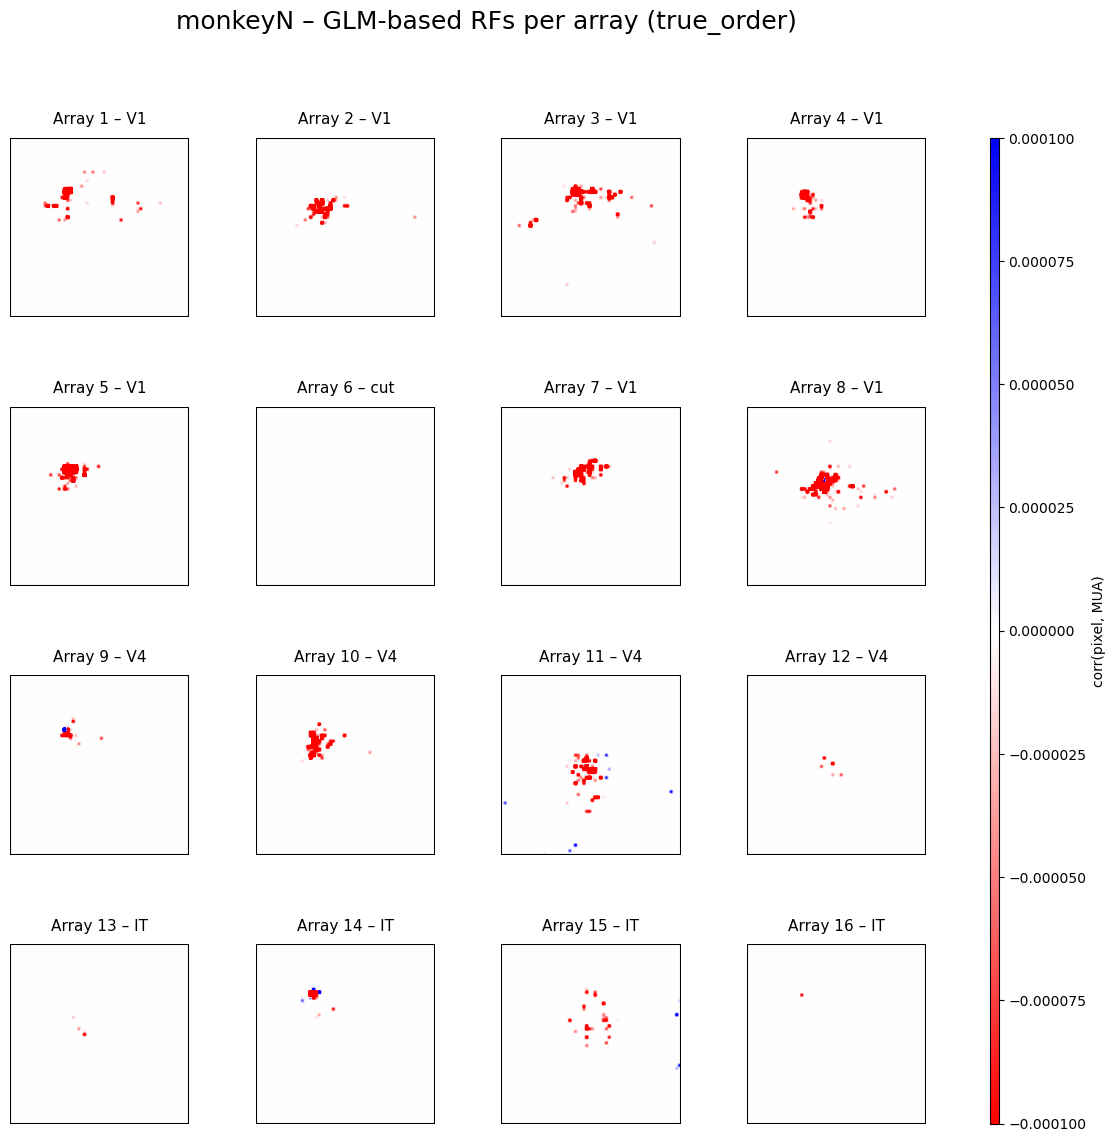

In [16]:

# plot 16 averaged RFs (Utah arrays)

plot_rf_grid(
    rf_per_array, array2area, vlim=vlim,
    monkey="monkeyN", shuffle_suffix=shuffle_suffix,
    save_dir=save_dir, basename=basename
)


In [17]:
rf_per_array.shape

(16, 64, 64)

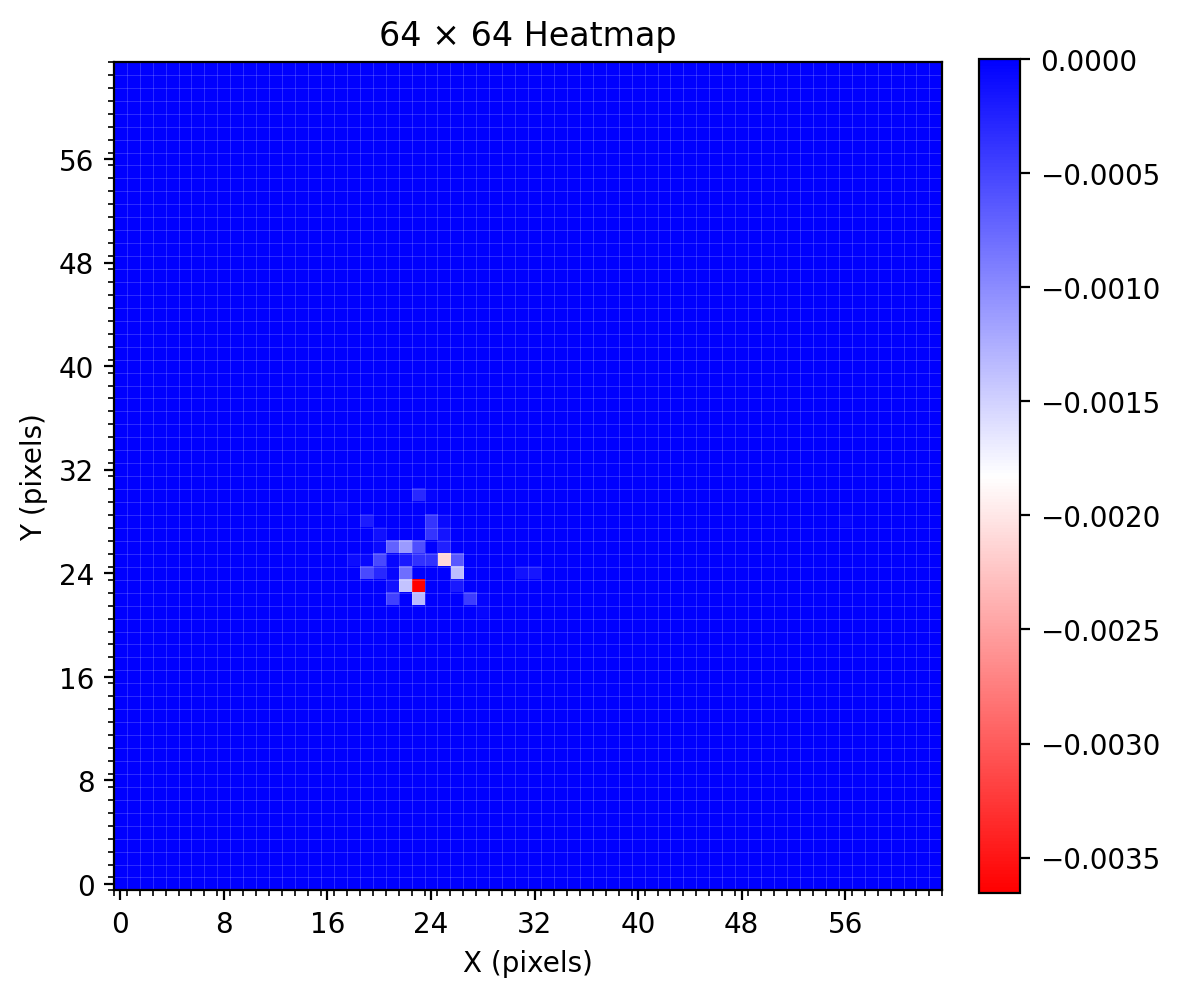

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Example input: shape (1, 64, 64)

heatmap = np.squeeze(rf_per_array[1,:,:])  # -> (64, 64)

fig = plt.figure(figsize=(6, 6), dpi=200)
gs = GridSpec(1, 1, figure=fig)

ax = fig.add_subplot(gs[0, 0])

im = ax.imshow(
    heatmap,
    origin='lower',
    cmap='bwr_r',
    interpolation='nearest',
)

# Force square pixels
ax.set_aspect('equal')

# Axis ticks: 0–63
ticks = np.arange(0, 64, 8)  # change step if you want denser ticks
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xlim(-0.5, 63.5)
ax.set_ylim(-0.5, 63.5)

ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
ax.set_title("64 × 64 Heatmap")

# Optional grid overlay (pixel grid)
ax.set_xticks(np.arange(-0.5, 64, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 64, 1), minor=True)
ax.grid(which='minor', color='white', linewidth=0.2, alpha=0.3)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# PLOTTING IN DVA SPACE

C:\Users\Radovan\AppData\Local\Temp\ipykernel_11620\392322669.py:42: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


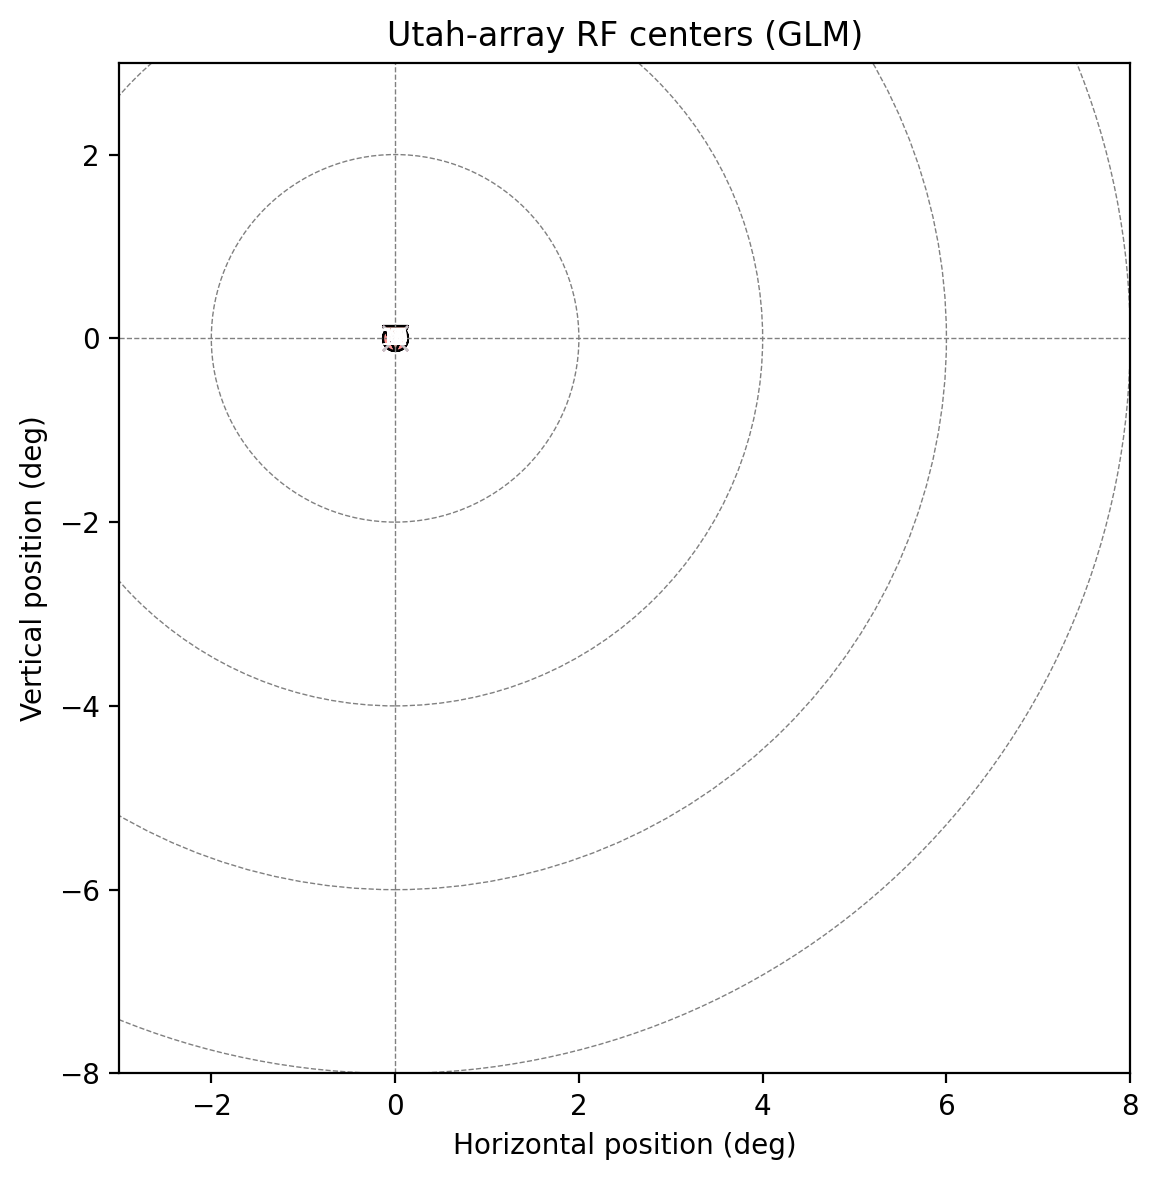

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# center_x_deg, center_y_deg: (16,)
# optional: array2area mapping (1-based)
# example:
# array2area = {
#     1:  'V1', 2: 'V1', 3: 'V1', 4: 'V1',
#     5:  'V1', 7: 'V1', 8: 'V1',
#     9:  'V4', 10: 'V4', 11: 'V4', 12: 'V4',
#     13: 'IT', 14: 'IT', 15: 'IT', 16: 'IT',
#     6:  'cut'
# }

fig, ax = plt.subplots(figsize=(6, 6), dpi=200)

# simple colormap: one color per array
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(16)]

for a in range(16):
    x = center_x_deg[a]
    y = center_y_deg[a]

    if np.isnan(x) or np.isnan(y):
        continue  # skip faulty array (e.g. array 6)

    if 'array2area' in globals():
        area = array2area.get(a + 1, 'unknown')
        if area == 'V1':
            marker = 'o'
        elif area == 'V4':
            marker = 'v'
        elif area == 'IT':
            marker = 'x'
        else:
            marker = 's'
    else:
        marker = 'o'

    ax.scatter(
        x, y,
        color=colors[a],
        marker=marker,
        edgecolors='black',
        linewidth=0.8,
        s=80,
        label=f"Array {a+1}" if a == 0 else None  # avoid spam in legend
    )
    ax.text(x, y, str(a+1), fontsize=8, ha='center', va='center', color='white')

# concentric circles in degrees
center = (0, 0)
radius = 8
num_circles = 4
for k in range(num_circles):
    circle = patches.Circle(
        center, radius * (k + 1) / num_circles,
        edgecolor='gray', linewidth=0.5, fill=False, linestyle='dashed'
    )
    ax.add_patch(circle)

ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)

ax.set_xlim(-3, 8)
ax.set_ylim(-8, 3)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal position (deg)')
ax.set_ylabel('Vertical position (deg)')
ax.set_title('Utah-array RF centers (GLM)')

plt.tight_layout()
plt.show()


In [20]:
def plot_all_RFs(horizontal_pos_MaxResponses_mean, vertical_pos_MaxResponses_mean, sizes, goodIDs, allColors, markerSize, offSet, text = False):
    AREA = ['V1'] * (64 * 8) + ['V4'] * (64 * 4) + ['IT'] * (64 * 4)
    
    # textOffset = 0.5
    stdCoeff = 1
    xOffset = offSet[0]
    yOffset = offSet[1]
    
    # Create subplots for each area
    fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=200)
    
    # Iterate over the areas
    for area, ax in zip(['V1', 'V4', 'IT'], axs.flatten()):
        ax.set_title(area, size = 20)  # Set the subplot title
        
        #### ellipses RFs
        for i in range(1024):
            if goodIDs[i] and AREA[i] == area:
                if area == 'V1':
                    hatch = None
                    alpha = 0.3
                elif area == 'V4':
                    hatch = '//////'
                    alpha = 0.03
                elif area == 'IT':
                    hatch = '///'
                    alpha = 0.01

                color = tuple(allColors[i])
                ellipse = patches.Ellipse((horizontal_pos_MaxResponses_mean[i] + xOffset, vertical_pos_MaxResponses_mean[i] + yOffset),
                                          width=sizes[i] * stdCoeff,
                                          height=sizes[i] * stdCoeff,
                                          edgecolor=color, linewidth=0.5,
                                          hatch=hatch,
                                          facecolor=color,
                                          alpha=alpha)
                ax.add_patch(ellipse)
        
        #### centers RFs
        for i in range(1024):
            if AREA[i] == area:
                if area == 'V1':
                    marker = 'o'
                    s = 5 * markerSize
                elif area == 'V4':
                    marker = 'v'
                    s = 10 * markerSize
                elif area == 'IT':
                    marker = 'x'
                    s = 10 * markerSize
        
                if goodIDs[i]:
                    color = tuple(allColors[i])
                    ax.scatter(horizontal_pos_MaxResponses_mean[i] + xOffset, 
                               vertical_pos_MaxResponses_mean[i] + yOffset, 
                               color=color,
                               marker=marker,
                               edgecolors='black',
                               linewidth=0.5,
                               s=s)
                    if text:
                        ax.annotate(str(i + 1),
                                    (horizontal_pos_MaxResponses_mean[i] + textOffset + xOffset, 
                                     vertical_pos_MaxResponses_mean[i] + textOffset + yOffset),
                                    size=4)
        
        # Concentric circles
        center = (0, 0)  # Center coordinates of the circles
        radius = 8  # Radius of the outermost circle
        num_circles = 4  # Number of concentric circles to draw
        
        for angle in range(num_circles):
            circle = patches.Circle(center, radius * (angle + 1) / num_circles, edgecolor='gray', linewidth=0.5,
                                    fill=False, linestyle='dashed')
            ax.add_patch(circle)
        
        textYstart = 1.1
        textXstart = 3
        ax.annotate('Angles in degrees', (textXstart - 0.3, textYstart), size=16)
        ax.annotate('circle,   plain      shade: V1', (textXstart, textYstart - 0.5), size=10)
        ax.annotate('triangle, dashed shade: V4', (textXstart, textYstart - 0.8), size=10)
        ax.annotate('crossed, dashed shade: IT', (textXstart, textYstart - 1.1), size=10)
        ax.annotate('colors are arrays', (textXstart, textYstart - 1.4), size=10)
        ax.annotate('Mr Nilson RFs', (textXstart + 0.5, -6.9), size=16)
        
        # Dashed lines at (0, 0)
        ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
        ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
        # ax.set_xlim(-1, 7)
        ax.set_xlim(-2, 8)
        ax.set_ylim(-7.5, 3.1)
        ax.set_aspect('equal')  # Set equal aspect ratio
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Plot all areas together in the fourth subplot
    ax = axs[1, 1]
    ax.set_title('All Areas')
    
    for i in range(1024):
        if goodIDs[i]:
            if AREA[i] == 'V1':
                hatch = None
                alpha = 0.3
            elif AREA[i] == 'V4':
                hatch = '//////'
                alpha = 0.03
            elif AREA[i] == 'IT':
                hatch = '///'
                alpha = 0.01
    
            color = tuple(allColors[i])
            ellipse = patches.Ellipse((horizontal_pos_MaxResponses_mean[i] + xOffset, vertical_pos_MaxResponses_mean[i] + yOffset),
                                      width=sizes[i] * stdCoeff,
                                      height=sizes[i] * stdCoeff,
                                      edgecolor=color, linewidth=0.5,
                                      hatch=hatch,
                                      facecolor=color,
                                      alpha=alpha)
            ax.add_patch(ellipse)
    
            if AREA[i] == 'V1':
                marker = 'o'
                s = 5 * markerSize
            elif AREA[i] == 'V4':
                marker = 'v'
                s = 10* markerSize
            elif AREA[i] == 'IT':
                marker = 'x'
                s = 10 * markerSize
    
            ax.scatter(horizontal_pos_MaxResponses_mean[i] + xOffset,
                       vertical_pos_MaxResponses_mean[i] + yOffset,
                       color=color,
                       marker=marker,
                       edgecolors='black',
                       linewidth=0.5,
                       s=s)
            if text:
                ax.annotate(str(i + 1),
                            (horizontal_pos_MaxResponses_mean[i] + offset + xOffset,
                             vertical_pos_MaxResponses_mean[i] + offset + yOffset),
                            size=4)
    
    # Concentric circles
    for angle in range(num_circles):
        circle = patches.Circle(center, radius * (angle + 1) / num_circles, edgecolor='gray', linewidth=0.5,
                                fill=False, linestyle='dashed')
        ax.add_patch(circle)

    ax.annotate('Angles in degrees', (textXstart - 0.3, textYstart), size=16)
    ax.annotate('circle,   plain      shade: V1', (textXstart, textYstart - 0.5), size=10)
    ax.annotate('triangle, dashed shade: V4', (textXstart, textYstart - 0.8), size=10)
    ax.annotate('crossed, dashed shade: IT', (textXstart, textYstart - 1.1), size=10)
    ax.annotate('colors are arrays', (textXstart, textYstart - 1.4), size=10)
    ax.annotate('Mr Nilson RFs', (textXstart + 0.5, -6.9), size=16)
    ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
    ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_xlim(-1, 7)
    ax.set_xlim(-2, 8)

    ax.set_ylim(-7.5, 3.1)
    ax.set_aspect('equal')
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the figure
    plt.show()

In [21]:

import pickle
rootpath = r"C:\Users\Radovan\OneDrive\Radboud\a_Internship\Antonio Lonzano\root\SlavsForSight\code\NIN_canon\MAPPING"
mapping_file_path = os.path.join(rootpath, 'results', 'mapping_MrNilson.pkl')

with open(mapping_file_path, 'rb') as file:
    
    map_nilson = pickle.load(file)

array_numbers = map_nilson['arrayNumbers']   # (1024,), values 1–16
array_colors  = map_nilson['arrayColor']     # (1024, 3)

horizontal = np.full(1024, np.nan)
vertical   = np.full(1024, np.nan)
sizes      = np.ones(1024) * 0.5  # arbitrary radius in deg, adjust as needed

for i in range(1024):
    a = array_numbers[i] - 1      # convert 1-based → 0-based
    x = center_x_deg[a]
    y = center_y_deg[a]

    if np.isnan(x) or np.isnan(y):
        continue  # faulty array (e.g. 6) => NaN, won't be plotted

    horizontal[i] = x
    vertical[i]   = y

goodIDs = ~np.isnan(horizontal) & ~np.isnan(vertical)
allColors = array_colors
markerSize = 8
offSet = [0, 0]


KeyboardInterrupt: 

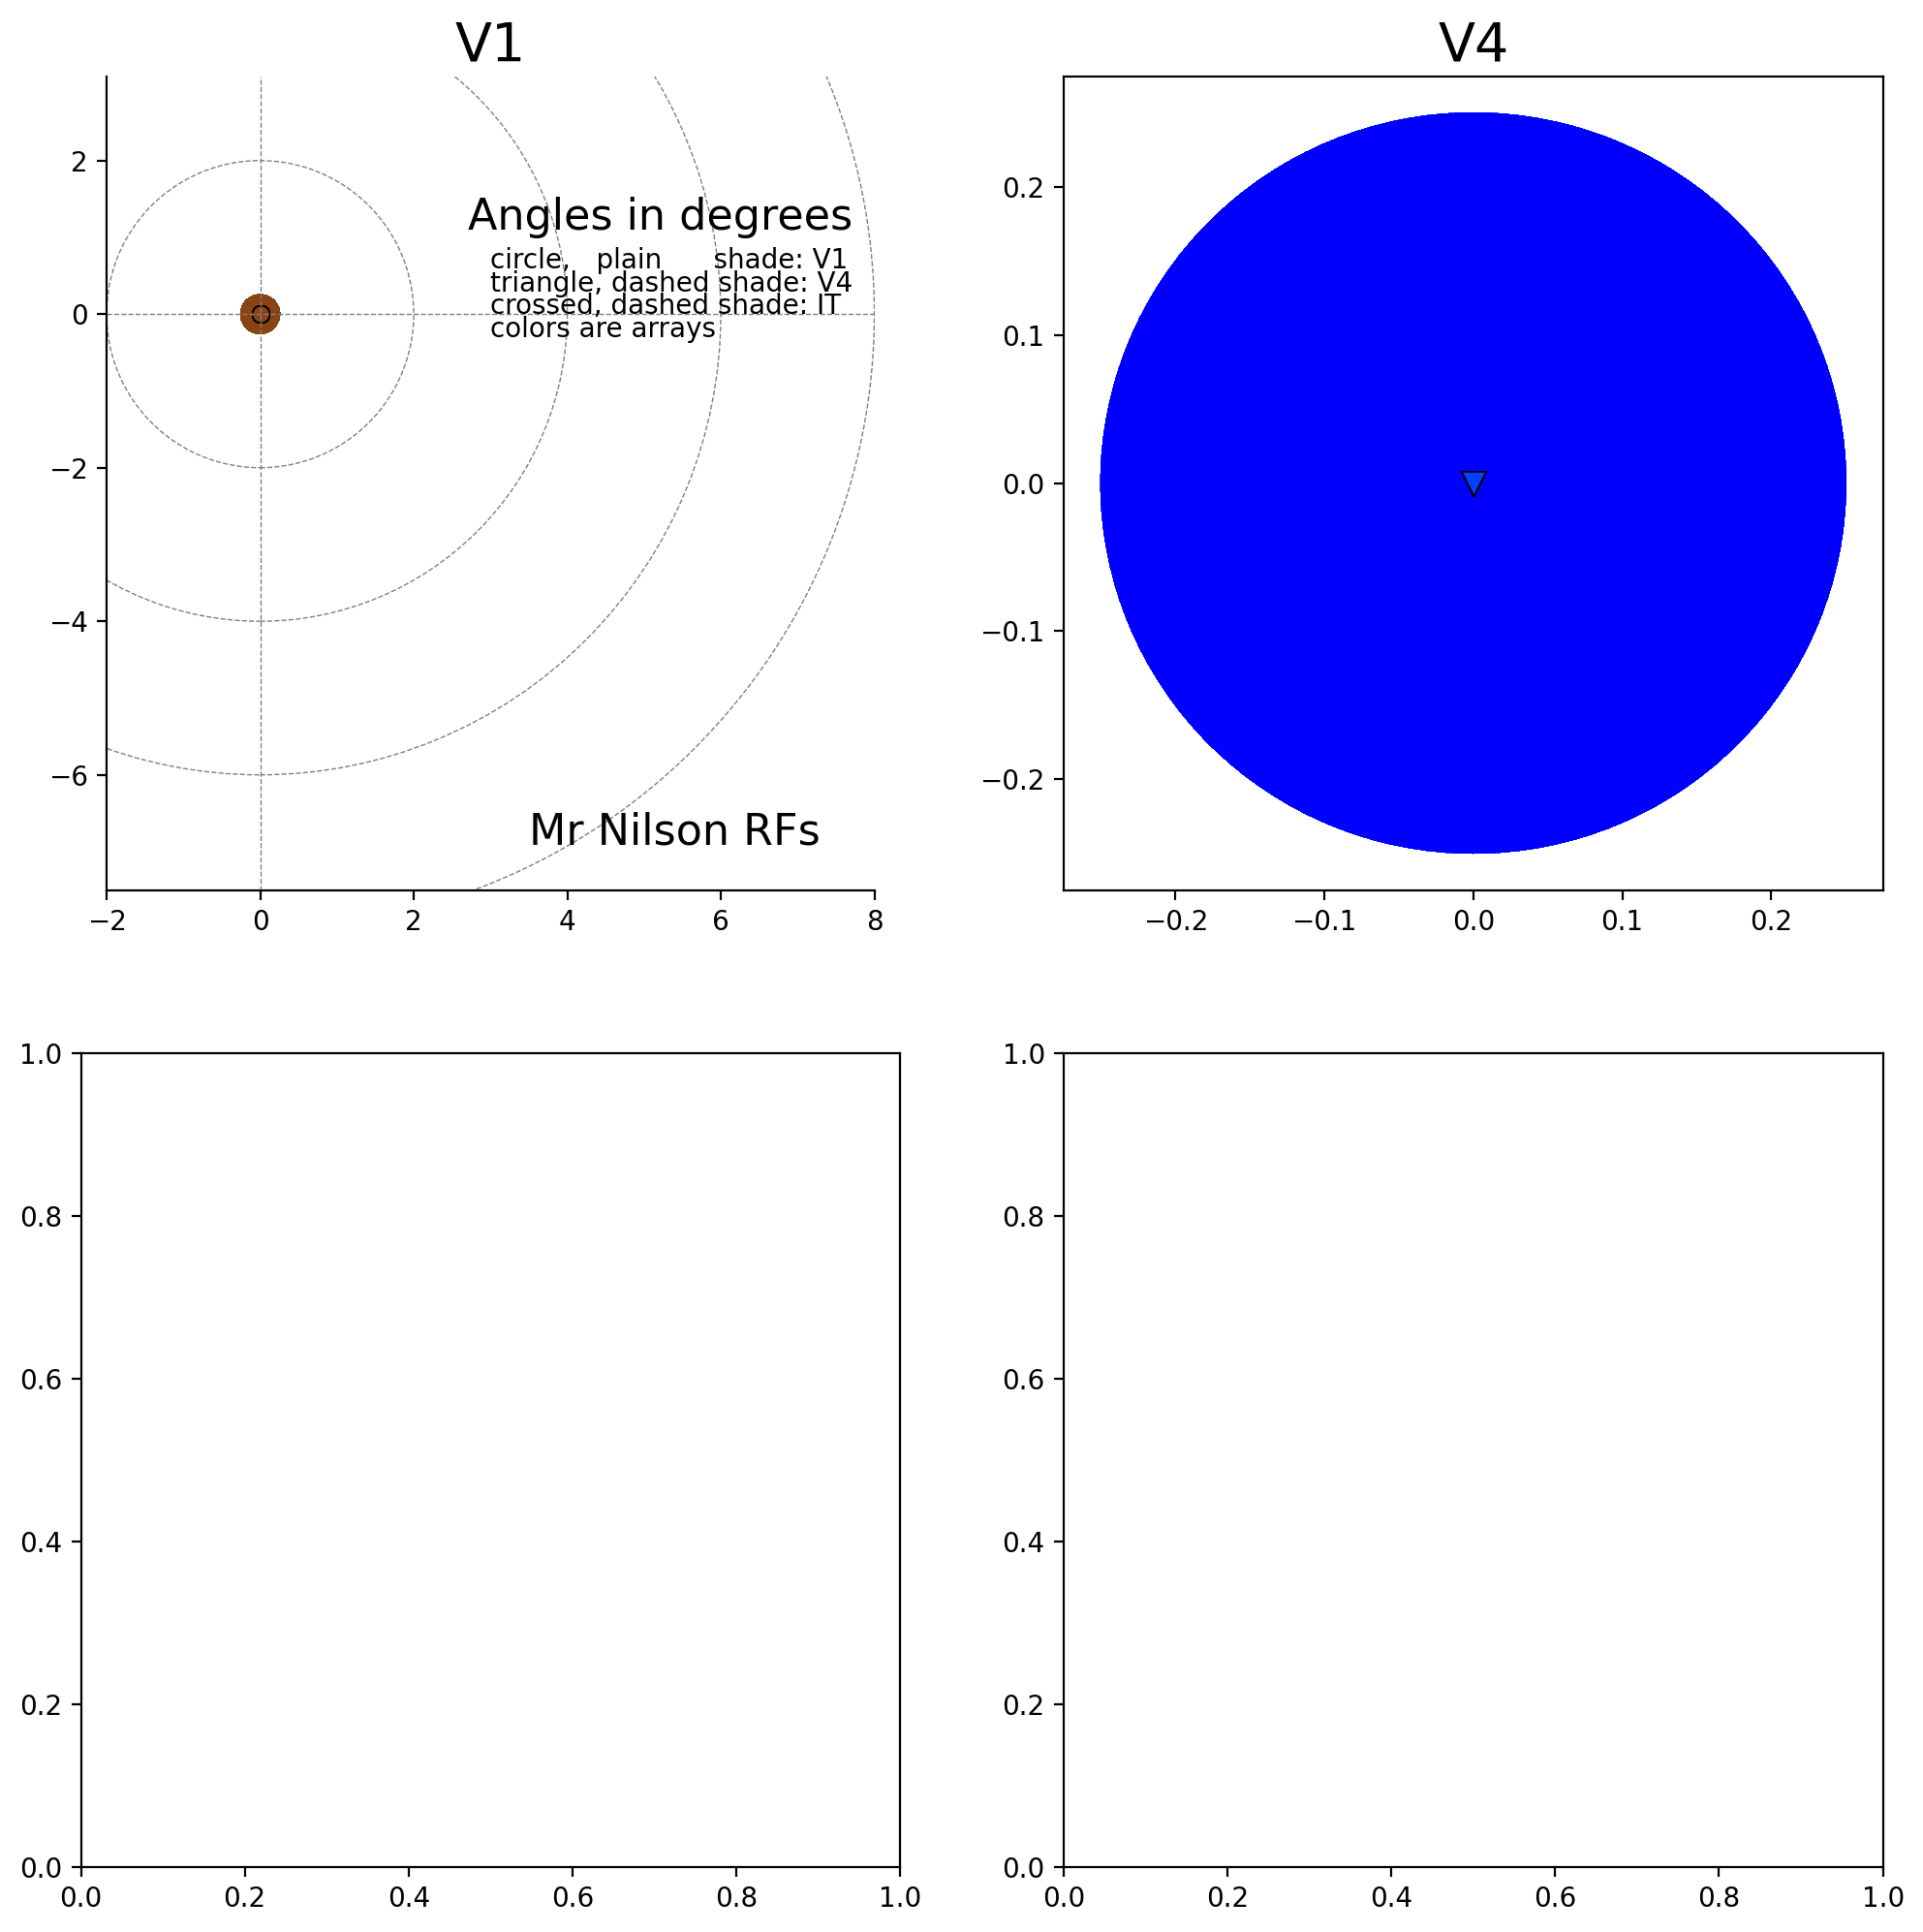

In [22]:
plot_all_RFs(
    horizontal_pos_MaxResponses_mean=horizontal,
    vertical_pos_MaxResponses_mean=vertical,
    sizes=sizes,
    goodIDs=goodIDs,
    allColors=allColors,
    markerSize=markerSize,
    offSet=offSet,
    text=False
)
